In [1]:
%matplotlib inline
import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

In [3]:
def sample_graph_from_infection(g):
    g_bone = g.copy()
    g = nx.Graph()
    g.add_nodes_from(g_bone)
    
    # sample active edges
    rands = np.random.random(g_bone.number_of_edges())
    
    probas = np.array([g_bone[i][j]['p'] for i, j in g_bone.edges_iter()])
    all_edges = g_bone.edges()
    active_edges = [all_edges[i] for i in (rands < probas).nonzero()[0]]

    g.add_edges_from(active_edges)
    
    for i, j in g.edges_iter():
        g[i][j]['tried'] = False
        g[i][j]['d'] = g_bone[i][j]['d']
        g[i][j]['p'] = g_bone[i][j]['p']        
        
    return g

In [4]:
def simulate_IC(g, s=None, debug=False):
    """return dict of node to infected times
    edges in g should contain the follow information:

    - d: the transmission delay
    - p: infection probability
    """
    infection_time = {n: float('inf') for n in g.nodes_iter()}
    bp = {n: None for n in g.nodes_iter()}  # back tracker
        
    g = sample_graph_from_infection(g)
    
    if debug:
        print(g.edges())
    if s is None:
        s = random.choice(g.nodes())
        
    queue = [s]
    t = 0
    infection_time[s] = t
    infection_paths = []
    while len(queue) > 0:
        outbreak_nodes = [u for u in queue if infection_time[u] <= t]
        queue = list(set(queue) - set(outbreak_nodes))
        infected_nodes = set()
        if debug:
            print('outbreak_nodes {}'.format(outbreak_nodes))
        for u in outbreak_nodes:
            for v in g.neighbors(u):
                if not g[u][v]['tried']:
                    if debug:
                        print('{} infects {}'.format(u, v))                    
                    g[u][v]['tried'] = True
                    if np.isinf(infection_time[v]):  # not infected yet
                        queue.append(v)

                    # update infection time
                    if (infection_time[u] + g[u][v]['d'] < infection_time[v]):
                        infection_time[v] = infection_time[u] + g[u][v]['d']
                        infected_nodes.add(v)
                        bp[v] = u
        if len(infected_nodes) == 0:
            break
        n = min(infected_nodes, key=lambda n: infection_time[n])
        t = infection_time[n]
    infection_tree = nx.Graph()
    infection_tree.add_nodes_from(g.nodes())
    del bp[s]
    infection_tree.add_edges_from(bp.items())
    return infection_time, infection_tree

In [82]:
g = nx.Graph()
a, b, c = 'a', 'b', 'c'
g.add_nodes_from([a, b, c])
g.add_edge(a, b, {'d': 3, 'p': 1})
g.add_edge(a, c, {'d': 1, 'p': 1})
g.add_edge(b, c, {'d': 1, 'p': 1})
t, tree = simulate_IC(g, s=a)
assert t == {'a': 0, 'b': 2, 'c': 1}
assert tree.edges() == [('a', 'c'), ('b', 'c')]

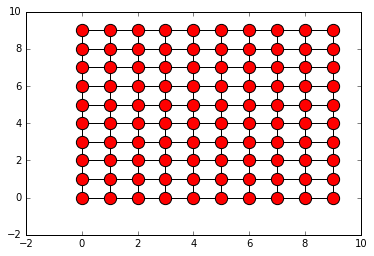

In [11]:
n = 10
g = nx.grid_2d_graph(n, n)
for i, j in g.edges_iter():
    g[i][j]['delay'] = 1
pos = {n: np.array(n) for n in g.nodes()}    
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=150)

In [5]:
def prepare_standard_infection_graph(g, p):
    for i, j in g.edges_iter():
        g[i][j]['p'] = p
        g[i][j]['d'] = 1
    return g


def get_display_kwargs(g, infected_times, obs_nodes=set(), max_node_size=1000):
    diff = 1
    times = np.array(list(infected_times.values()))
    times = times[np.invert(np.isinf(times))]
    upper_bound = times.max() + diff
    node_colors = [((upper_bound - infected_times[n] + diff) if not np.isinf(infected_times[n]) else 0)
                   for n in g.nodes()]
    def node_size(n):
        if n in obs_nodes:
            return max_node_size
        elif not np.isinf(infected_times[n]):
            return max_node_size / 4
        else:
            return max_node_size / 10
    node_sizes = list(map(node_size, g.nodes()))
    return {'node_size': node_sizes,
            'node_color': node_colors,
            'cmap': 'OrRd'}

In [6]:
def add_colorbar(cvalues, cmap='OrRd'):
    eps = np.maximum(0.0000000001, np.min(cvalues)/1000.)
    vmin = np.min(cvalues) - eps
    vmax = np.max(cvalues)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scm = mpl.cm.ScalarMappable(norm, cmap)
    scm.set_array(cvalues)
    plt.colorbar(scm)    

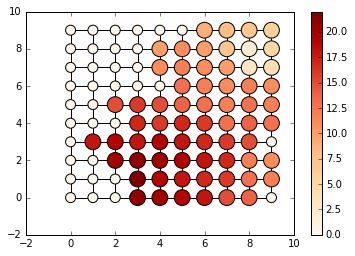

In [121]:
infp = 0.53
g = prepare_standard_infection_graph(g, infp)

infection_times, tree = simulate_IC(g)

kwargs =get_display_kwargs(g, infection_times)
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)
add_colorbar(kwargs['node_color'])


In [94]:
def make_input(g, infp, fraction, sampling_method='uniform'):
    while True:
        infection_times, tree = simulate_IC(g)

        cascade_size = np.count_nonzero(np.invert(np.isinf(list(infection_times.values()))))

        sample_size = int(cascade_size * fraction)
        infected_nodes = [n for n in g.nodes_iter() if not np.isinf(infection_times[n])]
        
        if sample_size > 1 and len(infected_nodes) > sample_size:
            break    
    if sampling_method == 'uniform':
        obs_nodes = set(random.sample(infected_nodes, sample_size))
    elif sampling_method == 'late_nodes':
        obs_nodes = set(sorted(infected_nodes, key=lambda n: -infection_times[n])[:sample_size])
    else:
        raise ValueError('unknown sampling methods')

    source = min(infection_times, key=lambda n: infection_times[n])
    if source in obs_nodes:
        obs_nodes.remove(source)
    orig_obs_nodes = copy(obs_nodes)    
    obs_infection_times = {n: infection_times[n] for n in obs_nodes}
    print("{}/{} samples".format(len(obs_nodes), cascade_size))
    return orig_obs_nodes, infection_times, tree

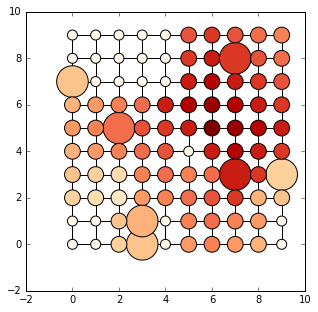

In [93]:
kwargs = get_display_kwargs(g, infection_times, obs_nodes)
fig = plt.figure(figsize=(5, 5))
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)

In [14]:

def simulate_on_node_as_source(g, s, K, order_constraint_n, obs_nodes, infection_times):
    success_cnt = 0
    if order_constraint_n:
        ordered_pairs = random.sample(list(combinations(obs_nodes, 2)), order_constraint_n)
        ground_truth = np.array([infection_times[u] > infection_times[v] for u, v in ordered_pairs])

    for i in range(K):
        times, _ = simulate_IC(g, s=s)
        inf_nodes = filter(lambda n: not np.isinf(times[n]), times)
        if obs_nodes.issubset(set(inf_nodes)):
            if order_constraint_n:
                reality = np.array([times[u] > times[v] for u, v in ordered_pairs])
                if (ground_truth == reality).all():
                    success_cnt += 1
            else:
                success_cnt += 1
    return s, success_cnt

def estimate_source_likelihood(g, K, M, obs_nodes, infection_times):
    result = Parallel(n_jobs=-1)(delayed(simulate_on_node_as_source)(g, s, K, M, obs_nodes, infection_times)
                                 for s in g.nodes())
    df = pd.DataFrame(result, columns=['node', 'cnt'])
    df['mu'] = df['cnt'] / K

    # stored here
    mu = {r['node']: r['mu'] for i, r in df.iterrows()}
    return mu

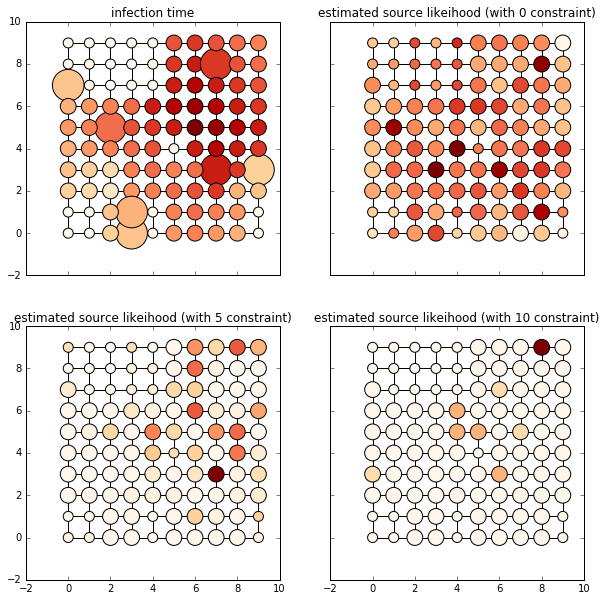

In [95]:
# source likelihood given observation
# using different number of constraints
K = 100
M = 5  # number of pairwise order constraints
fig, ax = plt.subplots(2, 2, num=1,
                       sharex=True, sharey=True,
                       figsize=(10, 10))


kwargs = get_display_kwargs(g, infection_times, obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 0].set_title('infection time')

def run_with_n_constraints(M, i, j):
    kwargs = get_display_kwargs(g, infection_times, obs_nodes=set())
    mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
    kwargs['node_color'] = [mu.get(n, 0) for n in g.nodes()]
    nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
    ax[i, j].set_title('estimated source likeihood (with {} constraint)'.format(M))
# add_colorbar(kwargs['node_color'])
run_with_n_constraints(0, 0, 1)
run_with_n_constraints(5, 1, 0)
run_with_n_constraints(10, 1, 1)


In [57]:
def simulate_given_passing_edge(g, q, u, s, K, M, max_attempts, infection_times, obs_nodes=set()):
    """
    q: query node
    u: direction node
    s: source node
    K: valid cascade number
    M: number of order pairs"""
    attempts = 0
    valid_cnt = 0  # valid if q and u is infected
    success_cnt = 0
    if M:
        ordered_pairs = random.sample(list(combinations(obs_nodes, 2)), M)
        ground_truth = np.array([infection_times[u] > infection_times[v] for u, v in ordered_pairs])

    
    while valid_cnt < K and attempts < max_attempts:
        attempts += 1
        time, tree = simulate_IC(g, s=s)
        if not np.isinf(time[q]) and not np.isinf(time[u]):
            valid_cnt +=1 
            if tree.has_edge(q, u) and time[q] - time[u] == g[q][u]['d']:
                inf_nodes = set(filter(lambda n: not np.isinf(time[n]), time))
                if obs_nodes.issubset(inf_nodes):
                    if M:
                        reality = np.array([time[u] > time[v] for u, v in ordered_pairs])
                        if (ground_truth == reality).all():
                            success_cnt += 1
                    else:
                        success_cnt += 1
    return s, success_cnt


In [58]:
def estimate_source_likelihood_given_edge(g, q, u, K, M,
                                          max_attempts, infection_times, obs_nodes):
    cands = set(g.nodes()) - {q} - set(g.neighbors(q)) - obs_nodes
    result = Parallel(n_jobs=-1)(delayed(simulate_given_passing_edge)(g, q, u, s=s, 
                                                                        K=K, M=M,
                                                                        max_attempts=max_attempts,
                                                                        infection_times=infection_times,
                                                                        obs_nodes=obs_nodes)
                                    for s in cands)
    df = pd.DataFrame(result, columns=['node', 'cnt'])
    df['mu'] = df['cnt'] / K

    # stored here
    mu = {r['node']: r['mu'] for i, r in df.iterrows()}
    return mu

(7, 7)
(6, 7)


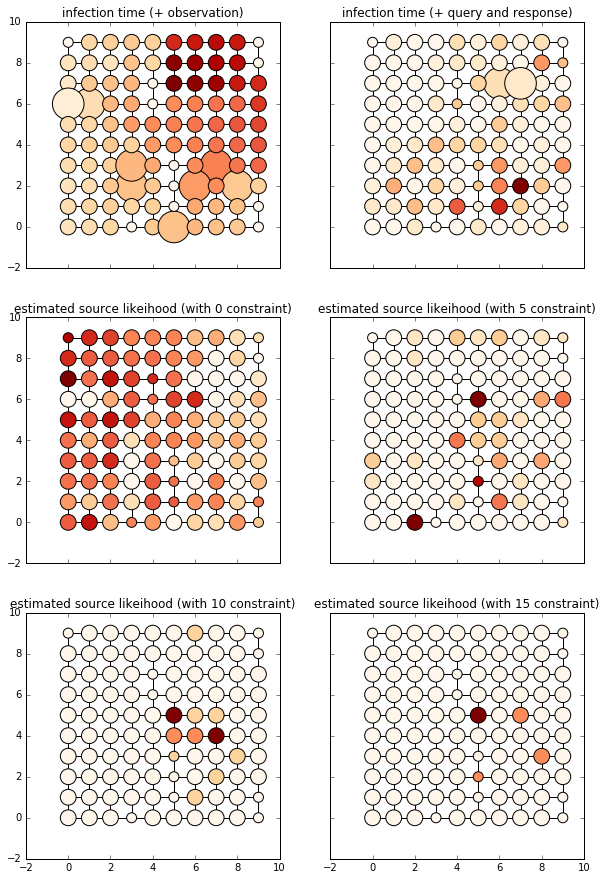

In [59]:
# fixing query and edge
# check the likelihood change with different number of node order constraints.
K = 50
M=5
max_attempts=200
q = random.choice(list(set(tree.nodes()) - obs_nodes))
print(q)
u = [u for u in g.neighbors(q)
     if infection_times[q] - infection_times[u] == g[q][u]['d']]
u = u[0]
print(u)

fig, ax = plt.subplots(3, 2, num=1, sharex=True, sharey=True,
                       figsize=(10, 15))


kwargs = get_display_kwargs(g, infection_times, obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 0].set_title('infection time (+ observation)')

kwargs = get_display_kwargs(g, infection_times, {q, u})
mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
kwargs['node_color'] = [mu.get(n) for n in g.nodes()]
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 1], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 1].set_title('infection time (+ query and response)')

def run_with_n_constraints(M, i, j):
    kwargs = get_display_kwargs(g, infection_times, obs_nodes=set())
    mu = estimate_source_likelihood_given_edge(g, q, u, K, M, max_attempts, infection_times, obs_nodes)
    kwargs['node_color'] = [mu.get(n, 0) for n in g.nodes()]
    nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
    ax[i, j].set_title('estimated source likeihood (with {} constraint)'.format(M))

run_with_n_constraints(0, 1, 0)
run_with_n_constraints(5, 1, 1)
run_with_n_constraints(10, 2, 0)
run_with_n_constraints(15, 2, 1)

In [133]:
print(infection_times[q])
print(infection_times[u])
q, u

3
2


((8, 6), (8, 5))

In [8]:
def get_nodes_on_and_off_direction(g, start, end):
    pos_nodes = set()
    neg_nodes = set()
    for t, path in nx.shortest_path(g, source=start).items():
        if len(path) == 1:
            pos_nodes.add(t)
        elif path[1] == end:
            # print(t, path)
            pos_nodes.add(t)
        else:
            neg_nodes.add(t)
    return pos_nodes, neg_nodes

In [138]:
q = (9, 7)
u = (8, 7)
pos_nods, neg_nodes = get_nodes_on_and_off_direction(g, q, u)

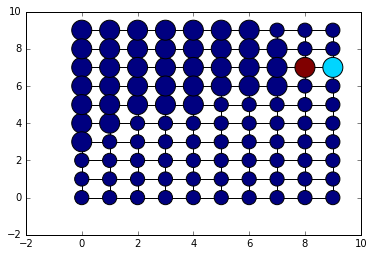

In [139]:
node_color = [1 if n == q else (3 if n == u else 0)
              for n in g.nodes() ]
nx.draw_networkx(g, pos=pos, 
                 node_color=node_color,
                 node_size=[400 if n in pos_nodes else 200 for n in g.nodes()],
                 with_labels=False)

In [41]:
# multiplicative weight update method
# initial mu
def mwu(g, orig_obs_nodes,
        infection_times, 
        p_on_mu, 
        mu, 
        max_iter, 
        max_plot_iter=11,
        debug=False, plot=False):
    use_sampling = False
    epsilon = 1e-5  # smoothing parameter
    obs_nodes = copy(orig_obs_nodes)
    K = 25
    M = len(obs_nodes)
    
    source = min(infection_times, key=lambda n: infection_times[n])
    

    K = 50
    max_attempts = 500

    sp_len = nx.shortest_path_length(g, weight='d')

    iter_i = 0

    if plot:
        ncols = 2
        nrows = math.ceil((max_plot_iter + 1) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        kwargs = get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
        ax[0, 0].set_title('ground truth')

    cands = set(g.nodes())
    if debug:
        print('correct source is {}'.format(source))
    all_nodes = set(g.nodes())
    queried_nodes = set()
    while iter_i < max_iter:
        def phi(q, g, mu, sp_len):
            return np.sum([mu[v] * sp_len[q][v] for v in g.nodes_iter()])
        q = min(all_nodes, key=lambda q: phi(q, g, mu, sp_len))
        if debug:
            print('query node: {}'.format(q))

        if plot and iter_i+1 <= max_plot_iter:
            kwargs = get_display_kwargs(g, mu, obs_nodes={q})
            likelihood_colors = [mu.get(n, 0) for n in g.nodes()]

            i, j = int((iter_i + 1) / ncols), (iter_i + 1) % ncols
            kwargs['node_color'] = likelihood_colors
            nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
            ax[i, j].set_title('iter_i={}'.format(iter_i))

        if q not in obs_nodes:
            obs_nodes.add(q)
            queried_nodes.add(q)

        if np.isinf(infection_times[q]):  # q is uninfected        
            if debug:
                print('query is uninfected')
            mu[q] = 0
        else:        
            if debug:
                print('query is infected')
            found_source = True
            for u in g.neighbors(q):                
                if u not in obs_nodes:  # need to query it
                    obs_nodes.add(u)
                    queried_nodes.add(u)

                if infection_times[q] > infection_times[u]:
                    # q later than u                    
                    found_source = False
                    # found the direction
                    if infection_times[q] - infection_times[u] == g[q][u]['d']:
                        mu[q] = 0
                        if q in cands:
                            cands.remove(q)
                        break
                else:
                    # q earlier than u
                    mu[u] = 0
                    if u in cands:
                        cands.remove(u)
            
            if found_source:
                source = q
                expected = min(infection_times, key=lambda n: infection_times[n])
                print('**Found** source: {}'.format(source))
                assert source == expected
                print('query count {}'.format(len(queried_nodes)))
                break
            else:
                assert infection_times[q] - infection_times[u] == g[q][u]['d']
                if use_sampling:
                    # update likelihood                      
                    if debug:
                        print('M={}'.format(len(obs_nodes)))                    
                    result = Parallel(n_jobs=-1)(delayed(simulate_given_passing_edge)(g, q=q, u=u, s=s,
                                                                                      obs_nodes=obs_nodes,
                                                                                      K=K, M=len(obs_nodes),
                                                                                      max_attempts=max_attempts,
                                                                                      infection_times=infection_times)
                                                 for s in cands)
                    df = pd.DataFrame(result, columns=['node', 'cnt'])
                    df['p'] = df['cnt'] / K
                    # update mu
                    for i, r in df.iterrows():
                        mu[r['node']] *= r['p']
                        mu[r['node']] += epsilon  # smoothing
                else:
                    pos_nodes, neg_nodes = get_nodes_on_and_off_direction(g, q, u)
                    for n in pos_nodes:
                        mu[n] *= p_on_mu ** sp_len[u][n]
                    for n in neg_nodes:
                        mu[n] *= (1 - p_on_mu) ** sp_len[u][n]
        total = sum(mu.values())
        mu = {n: (v / total) for n, v in mu.items()}  # normalize it
        # print(mu)
        if debug:
            print('mu[{}] = {}'.format(source, mu[source]))
        likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
        iter_i += 1
    return len(queried_nodes)
# def multiplicated_weight_update(g, mu, infection_time):

In [59]:
def baseline_dog_tracker(g, obs_nodes, infection_times):
    query_count = 0
    q = min(obs_nodes, key=lambda n: infection_times[n])
    while True:
        if q not in obs_nodes:
            query_count += 1
            obs_nodes.add(q)
            
        found_source = True
        for u in g.neighbors(q):
            if u not in obs_nodes:  # need to query it
                obs_nodes.add(u)
                query_count += 1            

            if infection_times[q] > infection_times[u]:
                # q later than u                    
                found_source = False
                # found the direction
                if infection_times[q] - infection_times[u] == g[q][u]['d']:
                    q = u
                    break
        if found_source:
            source = q
            expected = min(infection_times, key=lambda n: infection_times[n])
            print('**Found** source: {}'.format(source))
            assert source == expected            
            break
    return query_count
        


In [98]:
infp = 0.7
g = prepare_standard_infection_graph(g, infp)

p_on_mu = abs(infp-0.5) + 0.5
fraction = 0.05
K = 100
M = 5
N = 50
cnts = []
inputs = []
for i in range(N):
    print('experiment {}'.format(i+1))
    obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method='late_nodes')
    mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
    
    inputs.append(
        (obs_nodes, infection_times, tree, mu)
    )

    c = mwu(g, obs_nodes,
            infection_times, 
            p_on_mu,
            mu,
            max_iter=float('inf'), debug=False)
    cnts.append(c)
    print()

experiment 1
4/99 samples
**Found** source: (4, 5)
query count 7

experiment 2
4/99 samples
**Found** source: (0, 1)
query count 16

experiment 3
4/97 samples
**Found** source: (4, 8)
query count 42

experiment 4
4/92 samples
**Found** source: (5, 2)
query count 13

experiment 5
4/95 samples
**Found** source: (0, 8)
query count 17

experiment 6
4/99 samples
**Found** source: (1, 0)
query count 36

experiment 7
4/98 samples
**Found** source: (6, 2)
query count 22

experiment 8
4/96 samples
**Found** source: (3, 0)
query count 8

experiment 9
4/96 samples
**Found** source: (5, 5)
query count 11

experiment 10
4/98 samples
**Found** source: (2, 8)
query count 13

experiment 11
4/96 samples
**Found** source: (2, 6)
query count 34

experiment 12
4/98 samples


ZeroDivisionError: float division by zero

correct source is (0, 1)
query node: (1, 5)
query is infected
mu[(0, 1)] = 6.257131849455257e-06
query node: (0, 5)
query is infected
mu[(0, 1)] = 4.876914564570574e-06
query node: (0, 4)
query is infected
mu[(0, 1)] = 7.08798313689189e-06
query node: (0, 3)
query is infected
mu[(0, 1)] = 0.00011886972062577623
query node: (1, 4)
query is infected
mu[(0, 1)] = 0.0005362071511961829
query node: (2, 3)
query is infected
mu[(0, 1)] = 0.0004930820068003309
query node: (0, 2)
query is infected
mu[(0, 1)] = 0.324017283976397
query node: (1, 1)
query is infected
mu[(0, 1)] = 0.9088361354349997
query node: (0, 1)
query is infected
**Found** source: (0, 1)
query count 16


16

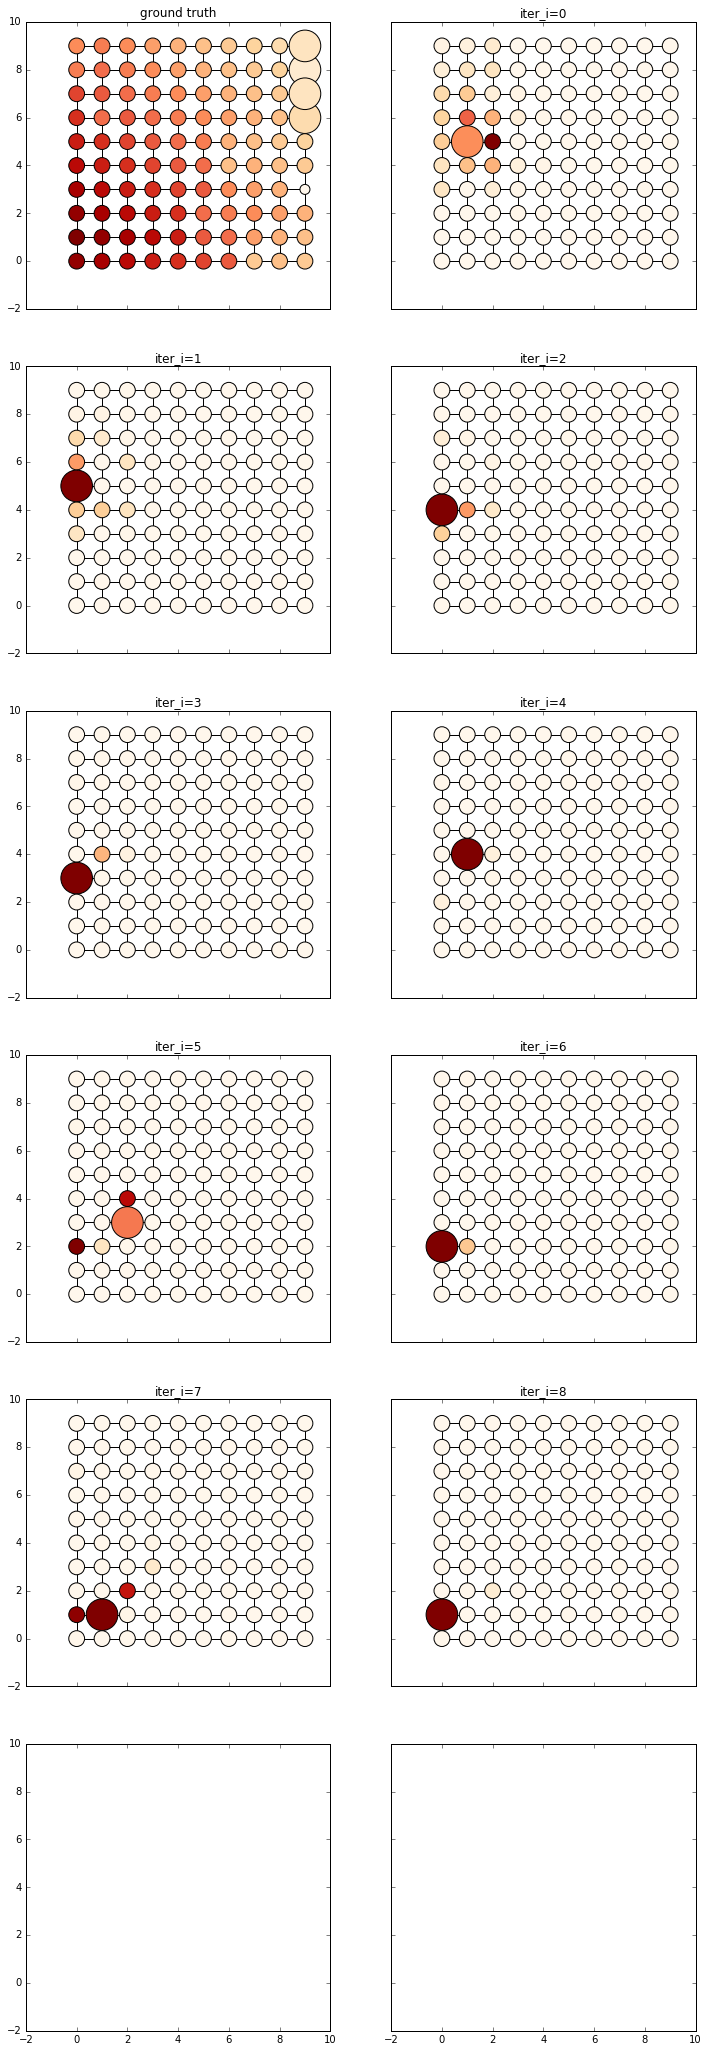

In [123]:
# manual inspection
bad_example1 = 11  # zero division
bad_example2 = 2  #  many querys
normal_example = 1
obs, times, tree, mu = inputs[normal_example]
# mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
mwu(g, obs, times, 
    p_on_mu=abs(infp-0.5) + 0.5,
    mu=mu,
    max_iter=float('inf'), debug=True, plot=True)

In [101]:
s1 = pd.Series(cnts)
s1.describe()

count    11.000000
mean     19.909091
std      12.070249
min       7.000000
25%      12.000000
50%      16.000000
75%      28.000000
max      42.000000
dtype: float64

In [102]:
cnts = []
for i in tqdm(range(N)):
    obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method='late_nodes')
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    cnts.append(c)

 36%|███▌      | 18/50 [00:00<00:00, 76.40it/s]

4/98 samples
**Found** source: (3, 7)
5/100 samples
**Found** source: (4, 8)
4/88 samples
**Found** source: (0, 9)
4/97 samples
**Found** source: (8, 5)
4/96 samples
**Found** source: (0, 9)
4/97 samples
**Found** source: (0, 9)
4/99 samples
**Found** source: (2, 8)
4/97 samples
**Found** source: (4, 7)
4/99 samples
**Found** source: (4, 4)
4/89 samples
**Found** source: (5, 8)
5/100 samples
**Found** source: (9, 1)
4/99 samples
**Found** source: (5, 1)
5/100 samples
**Found** source: (1, 7)
4/88 samples
**Found** source: (3, 8)
4/97 samples
**Found** source: (8, 5)
4/97 samples
**Found** source: (9, 7)
4/87 samples
**Found** source: (2, 5)
4/97 samples
**Found** source: (9, 5)
4/99 samples
**Found** source: (9, 0)
4/85 samples
**Found** source: (4, 1)
4/87 samples
**Found** source: (2, 9)


 82%|████████▏ | 41/50 [00:00<00:00, 89.45it/s]

4/96 samples
**Found** source: (5, 1)
4/96 samples
**Found** source: (9, 2)
5/100 samples
**Found** source: (9, 9)
4/90 samples
**Found** source: (0, 3)
4/96 samples
**Found** source: (4, 1)
5/100 samples
**Found** source: (3, 6)
4/96 samples
**Found** source: (9, 1)
4/97 samples
**Found** source: (7, 5)
4/97 samples
**Found** source: (9, 7)
5/100 samples
**Found** source: (2, 4)
4/96 samples
**Found** source: (3, 1)
4/96 samples
**Found** source: (1, 9)
4/89 samples
**Found** source: (3, 3)
4/99 samples
**Found** source: (2, 5)
4/97 samples
**Found** source: (0, 5)
4/95 samples
**Found** source: (3, 0)
5/100 samples
**Found** source: (1, 2)
4/96 samples
**Found** source: (1, 3)
5/100 samples
**Found** source: (1, 7)
4/93 samples
**Found** source: (8, 1)
4/94 samples
**Found** source: (3, 6)
4/95 samples
**Found** source: (6, 5)
5/100 samples
**Found** source: (0, 5)


100%|██████████| 50/50 [00:00<00:00, 99.20it/s]

4/98 samples
**Found** source: (7, 9)
4/97 samples
**Found** source: (4, 8)
4/97 samples
**Found** source: (0, 7)
4/99 samples
**Found** source: (1, 7)
4/97 samples
**Found** source: (4, 8)
4/96 samples
**Found** source: (3, 3)


In [103]:
s2 = pd.Series(cnts)
s2.describe()

count    50.000000
mean     23.660000
std       3.755866
min      17.000000
25%      21.250000
50%      23.500000
75%      26.000000
max      35.000000
dtype: float64

In [105]:
print('late nodes sampling')
cmp = pd.DataFrame.from_dict({'multiplicative': s1.describe(), 'baseline': s2.describe()})
cmp

late nodes sampling


,baseline,multiplicative
count,50.000000,11.000000
mean,23.660000,19.909091
std,3.755866,12.070249
min,17.000000,7.000000
25%,21.250000,12.000000
50%,23.500000,16.000000
75%,26.000000,28.000000
max,35.000000,42.000000


In [100]:
print('unfiorm sampling')
cmp

unfiorm sampling


,baseline,multiplicative
count,50.000000,39.000000
mean,10.180000,9.641026
std,3.947047,3.923527
min,4.000000,4.000000
25%,7.000000,7.500000
50%,9.000000,9.000000
75%,13.000000,11.000000
max,21.000000,28.000000


In [ ]:
infection_times = obs_infection_times
nodes = obs_nodes

In [ ]:
def reverse_infection():
    u = max(nodes, key=lambda n: infection_times[n])
    tmax = infection_times[u]
    O = copy(nodes)
    infection_times = copy(infection_times)
    queue = [u]
    found = False
    time = max(infection_times.values())
    m = defaultdict(set)
    while not found:
        obs_i = filter(lambda n: infection_times[n] == time, O)
        for u in obs_i:
            for v in g.neighbors(u):
                if u not in m[v] or (infection_times[u] < time - g[u][v]['d']):
                    m[v]